**A1.5 Solución de problemas**

**Nombre:** Carlos Hernández Márquez

**Matrícula:** 653602

**Firma de honor:**
"Doy mi palabra que he realizado esta actividad con integridad académica"

# **Introducción**

La predicción del desempeño académico de los estudiantes es un tema de gran relevancia, ya que permite identificar factores que influyen en las calificaciones finales y orientar estrategias de apoyo educativo. Existen múltiples variables que pueden afectar el rendimiento, desde características demográficas hasta hábitos de estudio y asistencia a clases.

En esta actividad, se utiliza una base de datos de 395 estudiantes que incluye información demográfica, acceso a internet, historial académico y calificaciones de los dos primeros periodos del curso. El objetivo es **predecir la calificación final (G3) de cada estudiante** mediante técnicas de regresión lineal múltiple. 

A través de la preparación de los datos, la identificación de valores atípicos, la generación de interacciones entre variables y el entrenamiento de un modelo estadístico, se busca evaluar qué tan bien es posible estimar el rendimiento final, así como explorar la relación entre las diferentes variables de entrada y el resultado académico.


# **Carga de datos**

En esta sección se procede a la **importación y exploración inicial** del conjunto de datos `Calificaciones.csv`. El objetivo es familiarizarse con la estructura de la base de datos, identificar los tipos de variables presentes y establecer una referencia de los datos crudos antes de aplicar cualquier transformación o modelado.

In [34]:
import pandas as pd 
df = pd.read_csv("A1.5 Calificaciones.csv")
df.head(11)

,Escuela,Sexo,Edad,HorasDeEstudio,Reprobadas,Internet,Faltas,G1,G2,G3
0,GP,F,18,2,0,no,6,5,6,6
1,GP,F,17,2,0,yes,4,5,5,6
2,GP,F,15,2,3,yes,10,7,8,10
3,GP,F,15,3,0,yes,2,15,14,15
4,GP,F,16,2,0,no,4,6,10,10
5,GP,M,16,2,0,yes,10,15,15,15
6,GP,M,16,2,0,yes,0,12,12,11
7,GP,F,17,2,0,no,6,6,5,6
8,GP,M,15,2,0,yes,0,16,18,19
9,GP,M,15,2,0,yes,0,14,15,15


Tras la carga del archivo en un `DataFrame` de `pandas` y la visualización de las primeras 11 observaciones, se puede apreciar que la base de datos contiene **10 variables** que combinan atributos demográficos, hábitos de estudio, historial académico y calificaciones parciales de los estudiantes. La información está organizada de manera tabular, donde cada fila corresponde a un estudiante y cada columna a una característica específica.

In [35]:
print("\nTipos de datos de cada variable:")
print(df.dtypes)


Tipos de datos de cada variable:
Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


Al inspeccionar los tipos de datos (`dtypes`) se observa lo siguiente:

- Variables categóricas de tipo `object`: `Escuela`, `Sexo`, `Internet`.  

- Variables numéricas de tipo `int64`: `Edad`, `HorasDeEstudio`, `Reprobadas`, `Faltas`, `G1`, `G2`, `G3`.

Esta diferenciación es fundamental para las siguientes etapas de **preprocesamiento**, ya que determina qué columnas requieren **codificación categórica** y cuáles pueden ser directamente utilizadas en modelos de regresión lineal.

# **Transformación de variables categóricas**

Antes de aplicar un modelo, es imprescindible que todas las variables de entrada sean **numéricas** y adecuadamente codificadas. Las variables categóricas deben ser transformadas para que el modelo pueda interpretarlas correctamente.  

En esta sección se realiza la **codificación de las variables categóricas** (`Escuela`, `Sexo`, `Internet`) mediante la técnica de *one-hot encoding*, generando variables dummy binarias que representan la presencia de cada categoría, evitando redundancias mediante `drop_first=True`.

Además, se presta atención a variables que, aunque parecen cuantitativas, en realidad representan **clases discretas**. Este es el caso de `HorasDeEstudio`, donde los valores numéricos indican rangos de tiempo de estudio en lugar de magnitudes continuas. Para capturar esta información de manera adecuada, se creó una codificación binaria de dos variables:

- `estudioMedio`: indica si el estudiante dedica de 2 a 5 horas de estudio.  
- `estudioAlto`: indica si el estudiante dedica más de 5 horas de estudio.  

Con esta representación, cada estudiante queda codificado de la siguiente manera:

| estudioMedio | estudioAlto | Interpretación |
|--------------|-------------|----------------|
| 0            | 0           | Estudio Bajo (<2 horas) |
| 1            | 0           | Estudio Medio (2-5 horas) |
| 0            | 1           | Estudio Alto (>5 horas) |


Esta codificación permite que la variable sea **binaria y interpretable** por el modelo de regresión, evitando ambigüedades que podrían surgir si se usaran los valores originales como enteros continuos.

In [ ]:
categoricas = ["Escuela", "Sexo", "Internet"]

df = pd.get_dummies(df, columns=categoricas, drop_first=True)

df["estudioMedio"] = (df["HorasDeEstudio"] == 2)
df["estudioAlto"] = (df["HorasDeEstudio"].isin([3,4]))

df = df.drop(columns=["HorasDeEstudio"])

df.head()


,Edad,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,estudioMedio,estudioAlto
0,18,0,6,5,6,6,False,False,False,True,False
1,17,0,4,5,5,6,False,False,True,True,False
2,15,3,10,7,8,10,False,False,True,True,False
3,15,0,2,15,14,15,False,False,True,False,True
4,16,0,4,6,10,10,False,False,False,True,False


Tras aplicar la codificación, se eliminó la columna original `HorasDeEstudio` y se visualizan las primeras 5 observaciones del `DataFrame` modificado. Esto permite comprobar que:

1. Las variables categóricas originales fueron reemplazadas por dummies binarias.  

2. La variable de horas de estudio fue adecuadamente transformada en dos columnas binarias que representan niveles de estudio de manera explícita.  


# **Identificación de valores atípicos en la variable "Faltas"**

La presencia de valores atípicos puede afectar significativamente la estimación de los coeficientes en un modelo de regresión lineal múltiple.  

Para detectar observaciones atípicas en la variable `Faltas`, se aplicó el **método de Tukey** con un factor `k=3`, utilizando el rango intercuartil (IQR). Este criterio considera como outliers aquellas observaciones que se encuentran a más de 3 veces el IQR por debajo del primer cuartil o por encima del tercer cuartil.

In [37]:
import numpy as np

q1 = df["Faltas"].quantile(0.25)
q3 = df["Faltas"].quantile(0.75)

iqr = q3 - q1

li = q1 - (3 * iqr)
ls = q3 + (3 * iqr)

out = np.where((df["Faltas"] <= li) | (df["Faltas"] >= ls))[0]

print("Observaciones atípicas en 'Faltas':")
df.iloc[out, :]


Observaciones atípicas en 'Faltas':


,Edad,Reprobadas,Faltas,G1,G2,G3,Escuela_MS,Sexo_M,Internet_yes,estudioMedio,estudioAlto
74,16,0,54,11,12,11,False,False,True,True,False
183,17,0,56,9,9,8,False,False,True,True,False
276,18,0,75,10,9,9,False,False,True,True,False
307,19,1,38,8,9,8,False,True,True,False,False
315,19,1,40,13,11,11,False,False,True,False,True


Tras la identificación, se detectaron estudiantes con un número de faltas extremadamente elevado, que exceden con creces la variabilidad típica del conjunto de datos.  

Dado que estos valores son **poco representativos de la población general del curso** y podrían sesgar el modelo, se optó por eliminarlos del `DataFrame`. 

In [38]:
filas_originales = df.shape[0]
print(f"Cantidad de filas originales: {filas_originales}")

Cantidad de filas originales: 395


Antes de la eliminación, la base de datos contaba con 395 observaciones.

In [39]:
df = df[(df["Faltas"] >= li) & (df["Faltas"] <= ls)]

Después de aplicar el criterio de Tukey y detectar los outliers en la variable `Faltas`, se procedió a **filtrar el DataFrame** para conservar únicamente aquellas observaciones dentro de los límites establecidos (`li` y `ls`).  

In [40]:
filas_restantes = df.shape[0]
print(f"Cantidad de filas restantes: {filas_restantes}")

Cantidad de filas restantes: 390


Tras la eliminación de las observaciones atípicas en la variable `Faltas`, la base de datos quedó depurada y contiene únicamente registros representativos de la población general del curso.  

# **Análisis de colinealidad mediante matriz de correlaciones**

Se generó una **matriz de correlaciones** entre todas las variables cuantitativas del dataset para evaluar posibles problemas de **colinealidad**. La colinealidad elevada entre predictores puede afectar la estabilidad y la interpretabilidad de los coeficientes en un modelo de regresión lineal múltiple.  

Columnas más correlacionadas: G2 y G3
Valor de correlación: 0.9047966735871248


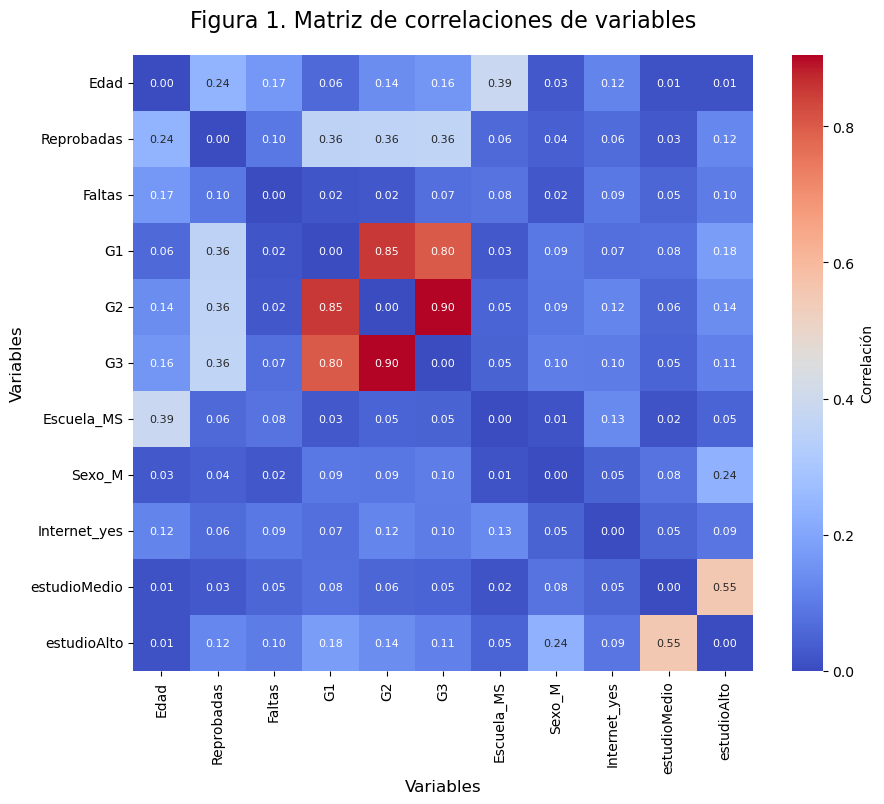

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cor = df.corr().abs()
np.fill_diagonal(cor.values, 0)

i, j = np.unravel_index(np.argmax(cor.values), cor.shape)
print("Columnas más correlacionadas:", df.columns[i], "y", df.columns[j])
print("Valor de correlación:", cor.values[i, j])

plt.figure(figsize=(10,8))

# Heatmap
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar_kws={'label': 'Correlación'}, annot_kws={"size":8})

plt.title("Figura 1. Matriz de correlaciones de variables", fontsize=16, pad=20)
plt.xlabel("Variables", fontsize=12)
plt.ylabel("Variables", fontsize=12)

plt.show()


El heatmap (Figura 1) permite visualizar de manera rápida las correlaciones absolutas entre todas las variables. A partir de la matriz calculada, se identificó que las variables **G2 (calificación del segundo periodo)** y **G3 (calificación final)** presentan una correlación extremadamente alta:

- **Columnas más correlacionadas:** G2 y G3  
- **Valor de correlación:** 0.905  

Dado que G3 es la variable objetivo que se pretende predecir, mantener G2 como predictor no representa un problema de colinealidad per se, sino que, por el contrario, proporciona información relevante para la predicción de la calificación final. 

Por lo tanto, **no se eliminará ninguna variable** en esta etapa, ya que todas las demás correlaciones presentan valores moderados que no comprometen la estabilidad del modelo.


# **Generación de términos de interacción**

Para capturar relaciones potencialmente no lineales entre variables explicativas, se procedió a generar **términos de interacción** para pares de variables seleccionadas de forma estratégica. En este caso, se decidió analizar las combinaciones **Faltas × estudioAlto** y **Sexo_M × estudioAlto**, ya que ambas presentan interés desde el punto de vista educativo y demográfico: las interacciones permiten explorar cómo el efecto de asistir más horas de estudio se modula según la presencia de faltas o el género del estudiante.

Antes de generar estas interacciones, se dividieron los datos en conjuntos de entrenamiento (80%) y prueba (20%), excluyendo la variable de salida `G3` para evitar fugas de información. Se empleó la función `train_test_split` de `sklearn.model_selection` para garantizar una separación reproducible (`random_state=42`).

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("G3",axis=1),df.G3,train_size = 0.8, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(312, 10)
(78, 10)
(312,)
(78,)


Las dimensiones resultantes fueron:

- `X_train`: 312 observaciones × 10 variables.

- `X_test`: 78 observaciones × 10 variables.

- `Y_train`: 312 observaciones.

- `Y_test`: 78 observaciones.

A continuación, se utilizó `PolynomialFeatures` con `interaction_only=True` y `include_bias=False` para generar un marco de referencia completo de interacciones posibles entre todas las variables de entrada, permitiendo contrastar los términos seleccionados de manera manual con los generados automáticamente.

In [43]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True,
                          include_bias=False).fit(X_train)

X_train_I = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names_out(X_train.columns))

X_train_I.head(10)

,Edad,Reprobadas,Faltas,G1,G2,Escuela_MS,Sexo_M,Internet_yes,estudioMedio,estudioAlto,...,Escuela_MS Sexo_M,Escuela_MS Internet_yes,Escuela_MS estudioMedio,Escuela_MS estudioAlto,Sexo_M Internet_yes,Sexo_M estudioMedio,Sexo_M estudioAlto,Internet_yes estudioMedio,Internet_yes estudioAlto,estudioMedio estudioAlto
0,18.0,0.0,8.0,14.0,13.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,16.0,0.0,2.0,10.0,9.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,17.0,0.0,2.0,10.0,11.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
3,18.0,0.0,4.0,10.0,10.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,17.0,1.0,0.0,6.0,5.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15.0,2.0,6.0,7.0,9.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,17.0,0.0,2.0,12.0,11.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
7,17.0,0.0,14.0,12.0,12.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
8,15.0,0.0,0.0,7.0,9.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
9,18.0,0.0,9.0,9.0,10.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Posteriormente, se generaron manualmente los dos términos de interacción seleccionados:

1. `Faltas_estudioAlto = Faltas × estudioAlto`  

2. `SexoM_estudioAlto = Sexo_M × estudioAlto`  

Estas interacciones se insertaron tanto en `X_train` como en `X_test` para garantizar consistencia entre los conjuntos.

In [44]:
# Crear interacción Faltas * estudioAlto
X_train.insert(10, "Faltas_estudioAlto", X_train["Faltas"] * X_train["estudioAlto"])
X_test.insert(10, "Faltas_estudioAlto", X_test["Faltas"] * X_test["estudioAlto"])

# Crear interacción Sexo_M * estudioAlto
X_train.insert(11, "SexoM_estudioAlto", X_train["Sexo_M"] * X_train["estudioAlto"])
X_test.insert(11, "SexoM_estudioAlto", X_test["Sexo_M"] * X_test["estudioAlto"])


X_train.head()

,Edad,Reprobadas,Faltas,G1,G2,Escuela_MS,Sexo_M,Internet_yes,estudioMedio,estudioAlto,Faltas_estudioAlto,SexoM_estudioAlto
294,18,0,8,14,13,False,True,True,False,True,8,True
63,16,0,2,10,9,False,False,True,False,True,2,False
241,17,0,2,10,11,False,True,True,True,False,0,False
358,18,0,4,10,10,True,True,True,False,False,0,False
221,17,1,0,6,5,False,False,False,False,True,0,False


In [45]:
X_test.head()

,Edad,Reprobadas,Faltas,G1,G2,Escuela_MS,Sexo_M,Internet_yes,estudioMedio,estudioAlto,Faltas_estudioAlto,SexoM_estudioAlto
9,15,0,0,14,15,False,True,True,True,False,0,False
42,15,0,2,19,18,False,True,True,True,False,0,False
33,15,0,0,8,10,False,True,True,True,False,0,False
316,18,0,0,8,8,False,False,True,True,False,0,False
274,17,0,2,10,10,False,False,True,True,False,0,False


In [46]:
# Comparar interacción Faltas * estudioAlto
print("Diferencias en Faltas_estudioAlto:", 
      sum(X_train_I["Faltas estudioAlto"].to_numpy() != X_train["Faltas_estudioAlto"].to_numpy()))

# Comparar interacción Sexo_M * estudioAlto
print("Diferencias en SexoM_estudioAlto:", 
      sum(X_train_I["Sexo_M estudioAlto"].to_numpy() != X_train["SexoM_estudioAlto"].to_numpy()))


Diferencias en Faltas_estudioAlto: 0
Diferencias en SexoM_estudioAlto: 0


La verificación comparativa con los términos generados automáticamente mostró **cero diferencias**, lo que confirma la correcta implementación de los términos manuales y su equivalencia con la aproximación general de `PolynomialFeatures`.

La inclusión de estas interacciones permite al modelo capturar efectos moduladores entre variables categóricas y cuantitativas, enriqueciendo la capacidad predictiva sin generar una explosión dimensional innecesaria. Las primeras 5 observaciones de `X_train` y `X_test` confirman que los términos fueron incorporados correctamente y presentan valores consistentes con las variables originales.


# **Entrenamiento del modelo de regresión lineal múltiple**

Se realizó la conversión explícita de todos los subconjuntos de datos a tipo `float` (`X_train_num`, `X_test_num`, `Y_train_num`, `Y_test_num`) para garantizar compatibilidad completa con `statsmodels.OLS`. Esta conversión previene errores en operaciones internas de matrices y asegura que tanto enteros como booleanos sean tratados como datos numéricos homogéneos durante la estimación de parámetros por mínimos cuadrados ordinarios.


In [ ]:
X_train_num = X_train.astype(float)
X_test_num = X_test.astype(float)

Y_train_num = Y_train.astype(float)
Y_test_num = Y_test.astype(float)

import statsmodels.api as sm
model = sm.OLS(Y_train_num, sm.add_constant(X_train_num))
results = model.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     129.5
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          1.08e-110
Time:                        01:36:49   Log-Likelihood:                -635.56
No. Observations:                 312   AIC:                             1297.
Df Residuals:                     299   BIC:                             1346.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.7794      1.680      1.059      0.290      -1.526       5.085
Edad                  -0.2257      0.101     -2.236      0.026      -0.424      -0.027
Reprobadas            -0.3001      0.171     -1.752      0.081      -0.637       0.037
Faltas                 0.0752      0.020      3.696      0.000       0.035       0.115
G1                     0.1876      0.063      2.986      0.003       0.064       0.311
G2                     0.9335      0.054     17.338      0.000       0.828       1.039
Escuela_MS             0.4349      0.384      1.132      0.259      -0.321       1.191
Sexo_M                 0.2628      0.266      0.987      0.324      -0.261       0.786
Internet_yes          -0.2027      0.296     -0.686      0.493      -0.784       0.379
estudioMedio           0.1414      0.280      0.505      0.614      -0.409       0.692
estudioAlto           -0.3225      0.462     -0.698      0.486      -1.232       0.587
Faltas_estudioAlto     0.0557      0.050      1.114      0.266      -0.043       0.154
SexoM_estudioAlto     -0.1477      0.557     -0.265      0.791      -1.243       0.948
==============================================================================
Omnibus:                      165.888   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              898.585
Skew:                          -2.233   Prob(JB):                    7.50e-196
Kurtosis:                      10.013   Cond. No.                         371.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

El modelo entrenado con todas las variables predictoras, incluidos los términos de interacción previamente definidos, muestra un **R-cuadrado ajustado de 0.832**, lo que indica que aproximadamente el 83% de la variabilidad en `G3` se explica por el modelo. Los coeficientes más significativos corresponden a `G2` y `G1`, reflejando que las calificaciones previas son los principales determinantes de la calificación final. 

In [ ]:
Y_pred = results.predict(sm.add_constant(X_test_num))
print("Primeras 5 predicciones de G3 en el conjunto de prueba:")
Y_pred[:5]


Primeras 5 predicciones de G3 en el conjunto de prueba:


9      15.223696
42     19.112622
33      9.430581
316     6.623678
274     9.241972
dtype: float64

Se utilizó el modelo entrenado para generar predicciones de `G3` sobre el subconjunto de prueba (`X_test_num`). La función `predict` de `statsmodels.OLS`, junto con la adición de la constante mediante `sm.add_constant`, permite calcular los valores estimados de la calificación final para cada observación. 

Las primeras cinco predicciones muestran la escala y magnitud de los valores generados, que pueden compararse posteriormente con los valores reales de `G3` para evaluar la precisión del modelo y la capacidad explicativa de las variables incluidas.

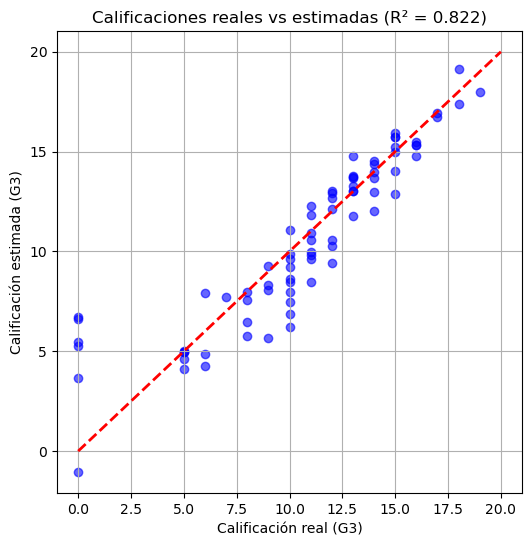

In [56]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test_num, Y_pred)
plt.figure(figsize=(6,6))
plt.scatter(Y_test_num, Y_pred, color='blue', alpha=0.6)
plt.plot([0, 20], [0, 20], color='red', linestyle='--', linewidth=2)  # línea perfecta
plt.xlabel("Calificación real (G3)")
plt.ylabel("Calificación estimada (G3)")
plt.title(f"Calificaciones reales vs estimadas (R² = {r2:.3f})")
plt.grid(True)
plt.show()

El gráfico de dispersión presenta en el eje x las calificaciones reales de los estudiantes (G3) y en el eje y las calificaciones estimadas por el modelo de regresión lineal múltiple. Cada punto representa una observación individual del conjunto de prueba. La línea roja discontinua corresponde a la línea de identidad (y = x), la cual indica predicciones perfectas. La proximidad de los puntos a esta línea evidencia la capacidad del modelo para capturar correctamente la tendencia general de las calificaciones.

El valor de R2=0.822 indica que aproximadamente el 82.2% de la variabilidad observada en las calificaciones finales se explica por las variables incluidas en el modelo, lo que refleja un ajuste fuerte y consistente. Las ligeras desviaciones de la línea de identidad sugieren que existen factores no incluidos o efectos no lineales que el modelo lineal no captura completamente.